In [7]:
import polars as pl
import glob
import os

def aggregate_jsonl_stats(directory_path="."):
    """
    Reads all .jsonl files in a directory and computes averages for 
    total_time and missing, and the count of successful instances.
    """
    # Pattern to match all .jsonl files
    file_pattern = os.path.join(directory_path, "folder_testcases*")
    jsonl_files = glob.glob(file_pattern)
    
    if not jsonl_files:
        print("No .jsonl files found in the specified directory.")
        return pl.DataFrame()

    results = []

    for file_path in jsonl_files:
        # Load the .jsonl file (ndjson)
        # Polars handles nested JSON, but we only need top-level keys
        df = pl.read_ndjson(file_path)
        
        # Calculate metrics for the current file
        stats = df.select([
            pl.lit(int(os.path.basename(file_path).rsplit("_")[-1])).alias("num_nets"),
            pl.col("total_time").mean().alias("avg_total_time"),
            pl.col("success").sum().alias("success_count"),
            pl.col("missing").mean().alias("avg_missing"),
            pl.col("missing").sum().alias("sum_missing"),
        ])
        
        results.append(stats)

    # Combine all individual file stats into one DataFrame
    summary_df = pl.concat(results)
    
    return summary_df

# Example usage:
ilp_results = aggregate_jsonl_stats("../final_val/densityresults/ilp")
ilp_results.sort(by="avg_total_time", descending=True).head()

num_nets,avg_total_time,success_count,avg_missing,sum_missing
i32,f64,u32,f64,i64
19,206.139401,100,0.0,0
18,194.814865,100,0.0,0
17,183.075923,100,0.0,0
16,171.555491,100,0.0,0
15,159.993224,100,0.0,0


In [16]:
astar_results = aggregate_jsonl_stats("../final_val/densityresults/astar")
astar_results.sort(by="success_count", descending=True).head(10)

num_nets,avg_total_time,success_count,avg_missing,sum_missing
i32,f64,u32,f64,i64
3,0.000118,100,0.0,0
4,0.00015,100,0.0,0
5,0.00061,99,0.01,1
8,0.000741,99,0.01,1
6,0.001084,98,0.03,3
7,0.000657,97,0.03,3
9,0.000765,97,0.03,3
12,0.001482,96,0.04,4
10,0.001477,95,0.06,6


In [9]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def process_and_plot(summary_df, title):
    """
    Plots statistics from a Polars DataFrame with a global title.
    """
    # Sort by num_nets for a logical progression on the x-axis
    summary_df = summary_df.sort("num_nets", descending=False)

    # Extract columns
    num_nets = summary_df["num_nets"].to_list()
    avg_times = summary_df["avg_total_time"].to_list()
    avg_times = [t * 1000 for t in avg_times]
    successes = summary_df["success_count"].to_list()
    avg_missing = summary_df["avg_missing"].to_list()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Add the Global Title
    fig.suptitle(title, fontsize=18, fontweight='bold', y=1.02)
    
    # Plot 1: Average Total Time
    axes[0].plot(num_nets, avg_times, color='skyblue')
    axes[0].set_title("Average Total Time (ms)")
    axes[0].set_ylabel("Seconds")

    # Plot 2: Success Count
    axes[1].bar(num_nets, successes, color='seagreen', edgecolor='black')
    axes[1].set_title("Number of Successes")
    axes[1].set_ylabel("Count"), 

    # Plot 3: Average Missing
    axes[2].bar(num_nets, avg_missing, color='salmon', edgecolor='black')
    axes[2].set_title("Average Missing Nets")
    axes[2].set_ylabel("Average")

    # Formatting all axes
    for ax in axes:
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
        ax.set_xticks(num_nets)
        ax.tick_params(axis='x', labelrotation=0) 
        ax.set_xlabel("Number of Nets")

    # Use constrained_layout or tight_layout with a rect adjustment 
    # to make room for the suptitle
    plt.tight_layout()
    
    return plt

<module 'matplotlib.pyplot' from '/home/kilianb/forschungsproj/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

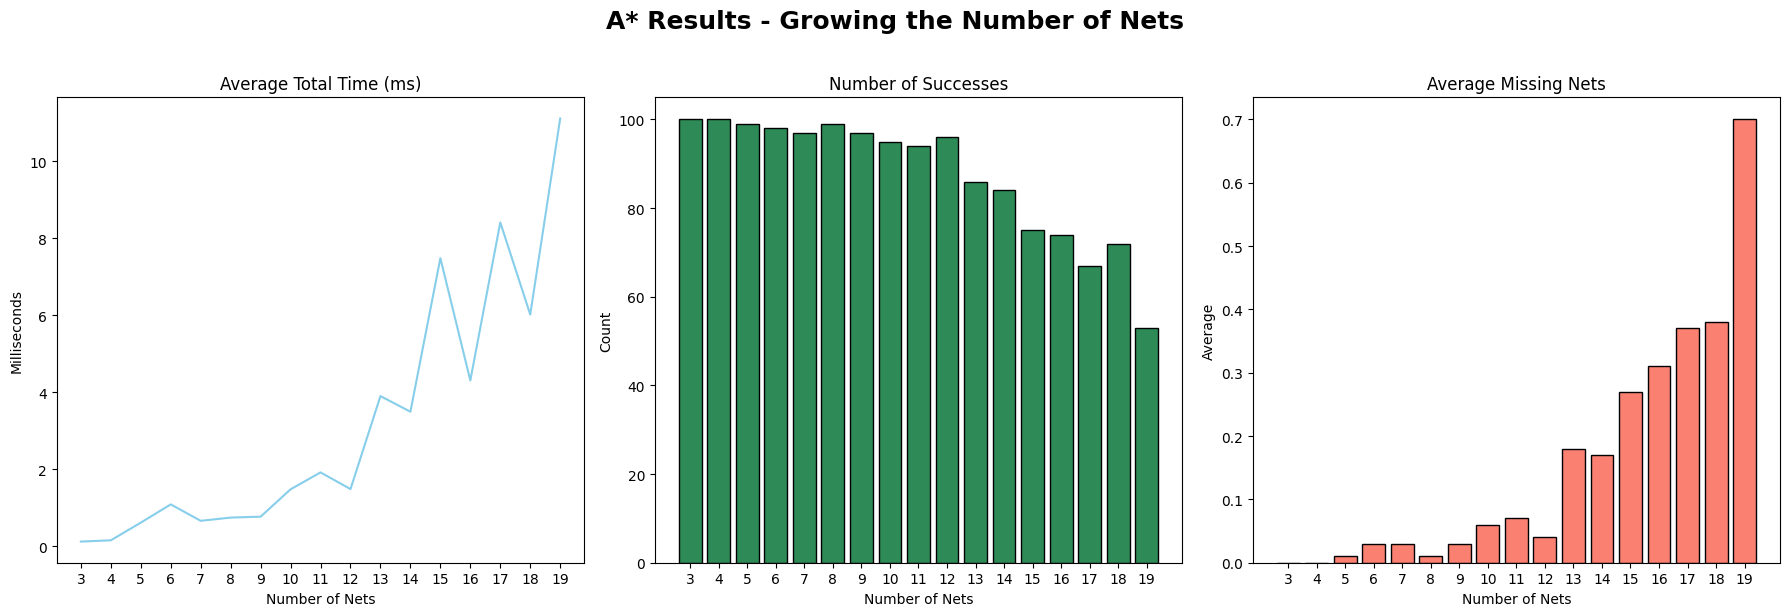

In [10]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

"""
Plots statistics from a Polars DataFrame with a global title.
"""
# Sort by num_nets for a logical progression on the x-axis
summary_df = astar_results
summary_df = summary_df.sort("num_nets", descending=False)

# Extract columns
num_nets = summary_df["num_nets"].to_list()
avg_times = summary_df["avg_total_time"].to_list()
avg_times = [t * 1000 for t in avg_times]
successes = summary_df["success_count"].to_list()
avg_missing = summary_df["avg_missing"].to_list()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Add the Global Title
fig.suptitle("A* Results - Growing the Number of Nets", fontsize=18, fontweight='bold', y=1.02)

# Plot 1: Average Total Time
axes[0].plot(num_nets, avg_times, color='skyblue')
axes[0].set_title("Average Total Time (ms)")
axes[0].set_ylabel("Milliseconds")

# Plot 2: Success Count
axes[1].bar(num_nets, successes, color='seagreen', edgecolor='black')
axes[1].set_title("Number of Successes")
axes[1].set_ylabel("Count")

# Plot 3: Average Missing
axes[2].bar(num_nets, avg_missing, color='salmon', edgecolor='black')
axes[2].set_title("Average Missing Nets")
axes[2].set_ylabel("Average")

# Formatting all axes
for ax in axes:
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax.set_xticks(num_nets)
    ax.tick_params(axis='x', labelrotation=0) 
    ax.set_xlabel("Number of Nets")

# Use constrained_layout or tight_layout with a rect adjustment 
# to make room for the suptitle
plt.tight_layout()
plt

<module 'matplotlib.pyplot' from '/home/kilianb/forschungsproj/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

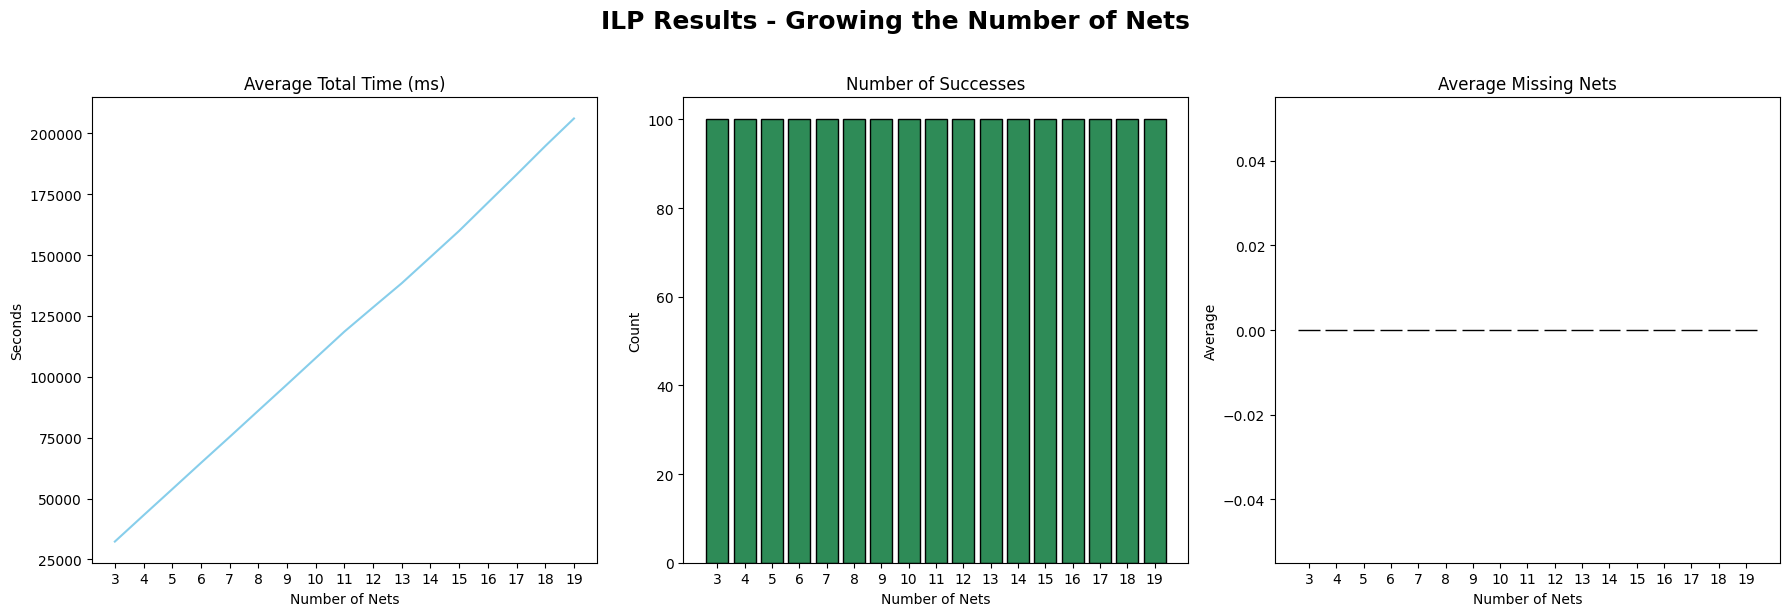

In [11]:
process_and_plot(ilp_results, "ILP Results - Growing the Number of Nets")

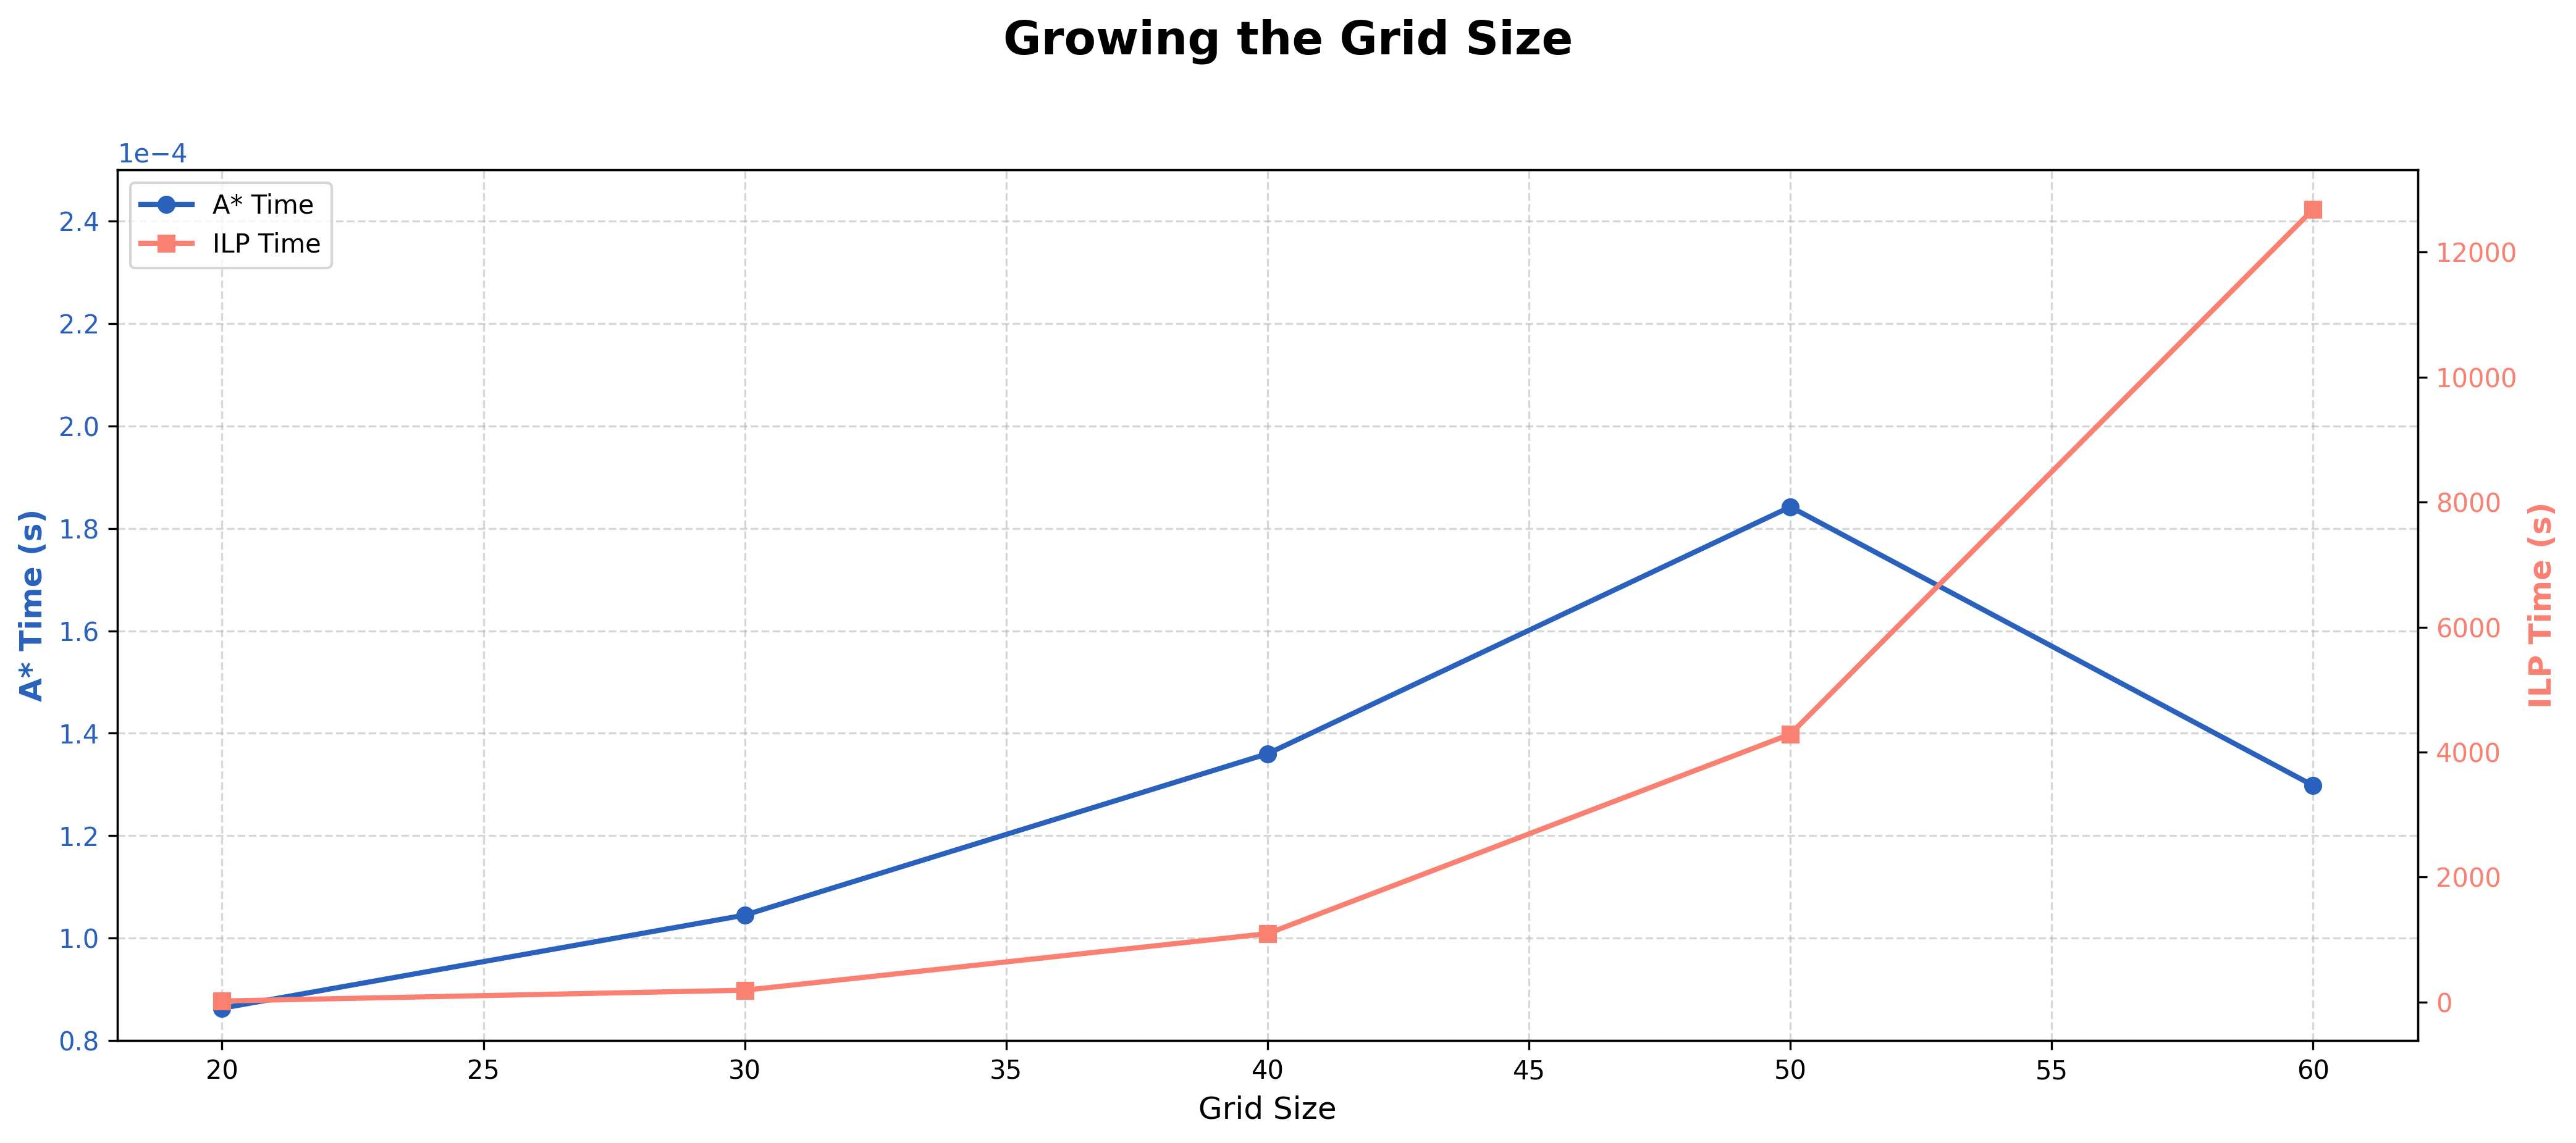

In [14]:
grid_sizes = [20, 30, 40, 50, 60]
times_astar = [.00008633, .0001045, .000136, .0001842, .0001298]
times_ilp = [16, 188.9187, 1094.776, 4286.5669, 12684.4453]
missing_astar = [0] * 5
missing_ilp = [0] * 5

fig, ax1 = plt.subplots(figsize=(14, 6), dpi=300)

# Global Title
fig.suptitle("Growing the Grid Size", fontsize=18, fontweight='bold', y=1.02)

# --- Plot 1: A* Time (Left Y-Axis) ---
color_astar = '#2961bc'
ax1.set_xlabel('Grid Size', fontsize=12)
ax1.set_ylabel('A* Time (s)', color=color_astar, fontsize=12, fontweight='bold')
ax1.plot(grid_sizes, times_astar, color=color_astar, marker='o', linewidth=2, label='A* Time')
ax1.tick_params(axis='y', labelcolor=color_astar)
ax1.set_ylim(.00008, .00025)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# --- Plot 2: ILP Time (Right Y-Axis) ---
# Instantiate a second axis that shares the same x-axis
ax2 = ax1.twinx() 

color_ilp = 'salmon' # Using a contrasting color
ax2.set_ylabel('ILP Time (s)', color=color_ilp, fontsize=12, fontweight='bold')
ax2.plot(grid_sizes, times_ilp, color=color_ilp, marker='s', linewidth=2, label='ILP Time')
ax2.tick_params(axis='y', labelcolor=color_ilp)

# Optional: Adding legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

fig.tight_layout()
plt.show()